<a href="https://colab.research.google.com/github/PSIPS/sniff-sniff/blob/main/dognosis_pranav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***PART 1: Exploratory Data Analysis (EDA):***

In [ ]:
!git clone https://gitlab.dognosis.link/pub/dogos-quest

Cloning into 'dogos-quest'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 85 (delta 2), reused 2 (delta 2), pack-reused 81 (from 1)
Receiving objects: 100% (85/85), 326.91 MiB | 8.55 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (59/59), done.


 Quick installs for all the libraries needed, like mne for EEG stuff and asrpy for cleaning



In [ ]:
!pip install mne
!pip install numpy
!pip install pandas
!pip install pathlib
!pip install asrpy

Importing everything, numpy pandas for data wrangling and plotting libraries too

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from asrpy import ASR


# 1. loading EEG and Calibration Data
eeg_file = '/content/dogos-quest/quest_eeg/060924-1700/Explore_84CF_ExG_ExG_stream_3.csv'
cal_file = '/content/dogos-quest/quest_eeg/060924-1700/calibration_exg.csv'
marker_file = '/content/dogos-quest/quest_eeg/060924-1700/Explore_84CF_Marker_Markers_stream_1.csv'

df_eeg = pd.read_csv(eeg_file)
df_cal = pd.read_csv(cal_file)
df_markers = pd.read_csv(marker_file)

# labeling
labels = ['Ch_1','Ch_2','Ch_3','Ch_4','Ch_5','Ch_6','Ch_7','Ch_8']
df_eeg.columns = ['Timestamps'] + labels
df_cal.columns = ['Timestamps'] + labels


Creating RawArray with float64 data, n_channels=8, n_times=103025
    Range : 0 ... 103024 =      0.000 ...   103.024 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=366512
    Range : 0 ... 366511 =      0.000 ...   366.511 secs
Ready.


###**1.1 Preprocessing and extracting meaningful features from EEG and sniffing activity**

Preprocessing - here i'm applying ASR (artifact subspace reconstruction) to clean up the raw EEG signals.

In [ ]:
# 2. Preparing Calibration Data for ASR
sfreq = 1000.0
cal_data = df_cal[labels].values.T
eeg_data = df_eeg[labels].values.T

info = mne.create_info(ch_names=labels, ch_types=['eeg']*len(labels), sfreq=sfreq)
raw_cal = mne.io.RawArray(cal_data, info)
raw_eeg = mne.io.RawArray(eeg_data, info)

# 3. ASR applied
asr = ASR(sfreq=int(sfreq))
asr.fit(raw=raw_cal)
raw_clean = asr.transform(raw=raw_eeg)

# 4. restore timestamps
filtered_data = raw_clean.get_data().T

df_clean = pd.DataFrame(filtered_data, columns=labels)
df_clean['Timestamps'] = df_eeg['Timestamps']
df_clean = df_clean[['Timestamps'] + labels]


# 5. Assign Sniffing Labels
df_clean['sniffing'] = 0
def assign_sniffing_label(df, marker_df):
    for marker_timestamp in marker_df['Timestamps']:
        start = marker_timestamp - 0.2
        end = marker_timestamp + 0.8
        df.loc[(df['Timestamps'] >= start) & (df['Timestamps'] <= end), 'sniffing'] = 1
    return df

df_clean = assign_sniffing_label(df_clean, df_markers)




plotted the cleaned EEG signals and added markers wherever 'sw_1' event happened

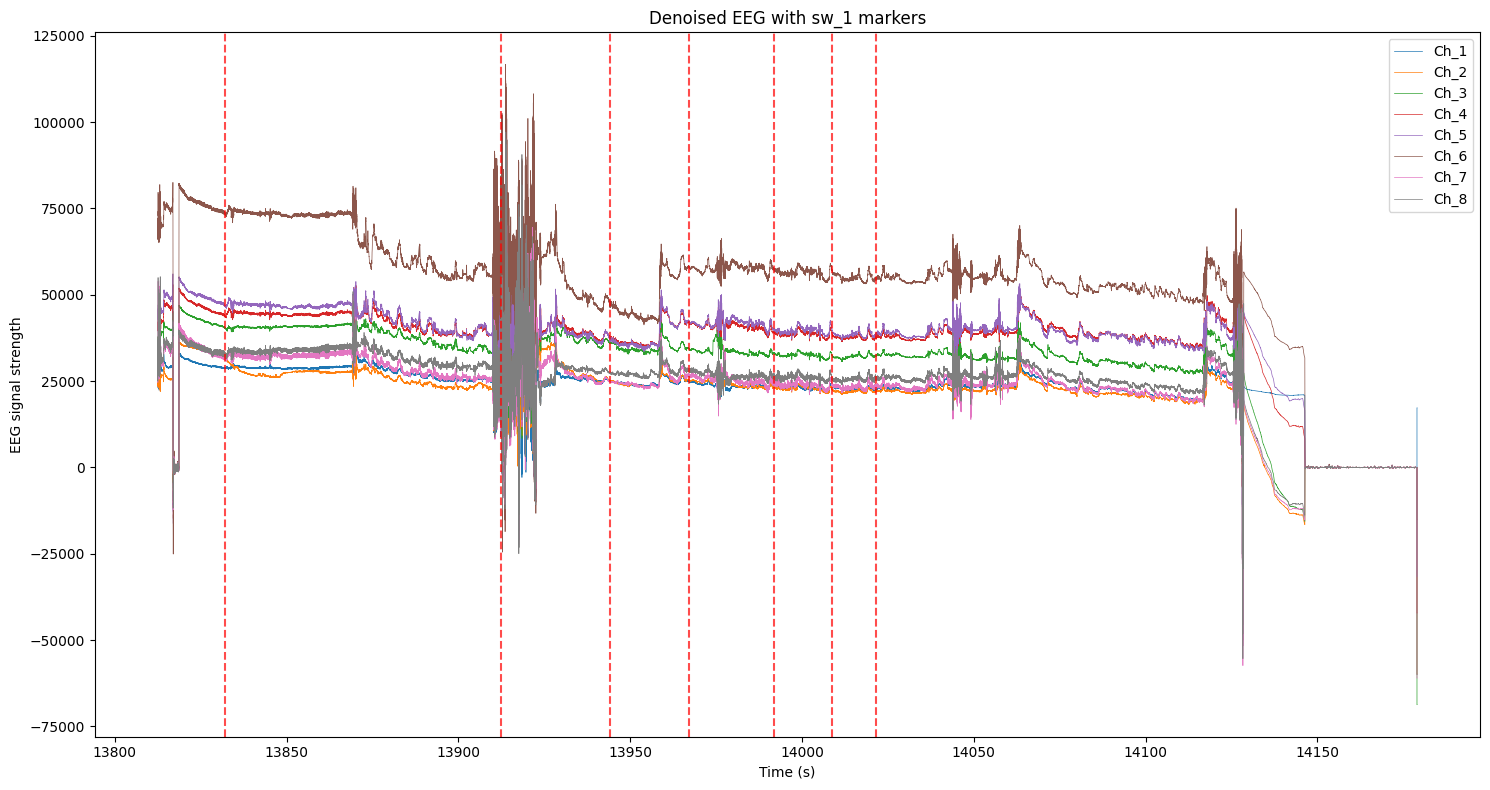

eeg_clean_060924-1700.csv


In [ ]:
# 6. Plot Full EEG with sw_1 Markers
plt.figure(figsize=(15, 8))
for ch in labels:
    plt.plot(df_clean['Timestamps'], df_clean[ch], label=ch, linewidth=0.5)
for t in df_markers['Timestamps']:
    plt.axvline(t, color='r', linestyle='--', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("EEG signal strength")
plt.legend()
plt.title("Denoised EEG with sw_1 markers")
plt.tight_layout()
plt.show()


# 7. Export Data
df_clean.to_csv("eeg_clean_060924-1700.csv", index=False)
print("eeg_clean_060924-1700.csv")

Loading the IR sensor data now to try and sync it up with the EEG later

In [ ]:
# 8. Load IR Data
ir_file = '/content/dogos-quest/quest_IR/060924-1700/IRMotionSensors_IR_stream_8.csv'
df_ir   = pd.read_csv(ir_file)

# Assign IR channel names
ir_labels = [f"IR_Ch_{i}" for i in range(1,9)]
df_ir.columns = ['Timestamps'] + ir_labels

# look at the df
print("IR data shape:", df_ir.shape)
df_ir[ ['Timestamps'] + ir_labels ].head()


IR data shape: (365051, 9)


,Timestamps,IR_Ch_1,IR_Ch_2,IR_Ch_3,IR_Ch_4,IR_Ch_5,IR_Ch_6,IR_Ch_7,IR_Ch_8
0,13812.481697,0,0,0,0,0,0,0,0
1,13812.482682,0,0,0,0,0,0,0,0
2,13812.483684,0,0,0,0,0,0,0,0
3,13812.484758,0,0,0,0,0,0,0,0
4,13812.485707,0,0,0,0,0,0,0,0


Just checking how many '1' events happened in IR channel 8

In [ ]:
count_ones = df_ir['IR_Ch_8'].value_counts().get(1, 0)
print(count_ones)

4906


getting the EEG and IR data ready for merging by nearest timestamp(using as_of), coz both have their own timestamps

In [ ]:
# we have df_clean (EEG) and df_ir (IR); now -

# 1) Creating a TimedeltaIndex column for merging
df_clean = df_clean.copy()
df_ir    = df_ir.copy()

df_clean['time'] = pd.to_timedelta(df_clean['Timestamps'], unit='s')
df_ir   ['time'] = pd.to_timedelta(df_ir   ['Timestamps'], unit='s')

# 2) Sorting both DataFrames by that new time column
df_clean = df_clean.sort_values('time')
df_ir    = df_ir.sort_values('time')

# 3) Selecting the IR columns you want to bring in
ir_cols = [col for col in df_ir.columns if col.startswith('IR_Ch_')]

# 4)Performing an as-of merge (with +_ 10ms range)
merged_nn = pd.merge_asof(
    df_clean,
    df_ir[['time'] + ir_cols],
    on='time',
    direction='nearest',
    tolerance=pd.Timedelta('10ms')   # adjust tolerance to your devices' max clock skew
)

# 5) Forward‐fill any remaining NaNs in the IR columns
merged_nn[ir_cols] = merged_nn[ir_cols].fillna(method='ffill')

# 6.Droping the auxiliary 'time' column if you no longer need it
merged_nn = merged_nn.drop(columns=['time'])

# Inspect the result
print(merged_nn.head())


     Timestamps      Ch_1      Ch_2      Ch_3      Ch_4      Ch_5      Ch_6  \
0  13812.475151  26134.02  23814.39  36841.35  40314.49  43690.40  67012.27   
1  13812.476151  26149.66  23804.00  36821.89  40286.69  43662.84  66962.30   
2  13812.477151  26180.32  23821.40  36836.63  40281.40  43647.96  66870.98   
3  13812.478151  26242.69  23858.93  36877.30  40257.89  43589.17  66597.37   
4  13812.479151  26198.34  23779.54  36760.05  40047.03  43333.82  66384.51   

       Ch_7      Ch_8  sniffing  IR_Ch_1  IR_Ch_2  IR_Ch_3  IR_Ch_4  IR_Ch_5  \
0  26486.92  26950.41         0        0        0        0        0        0   
1  26406.72  26875.93         0        0        0        0        0        0   
2  26151.80  26640.04         0        0        0        0        0        0   
3  25471.45  25982.67         0        0        0        0        0        0   
4  25409.42  25874.09         0        0        0        0        0        0   

   IR_Ch_6  IR_Ch_7  IR_Ch_8  
0        0   

<ipython-input-31-0d0ec5f6d641>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_nn[ir_cols] = merged_nn[ir_cols].fillna(method='ffill')


after merging EEG and IR, rechecking the count of channel_8 events in the synced data having value 1

In [ ]:
count_ones = merged_nn['IR_Ch_8'].value_counts().get(1, 0)
print(count_ones)

4929


### *Fig. Correlation heatmap b/w EEG & IR*

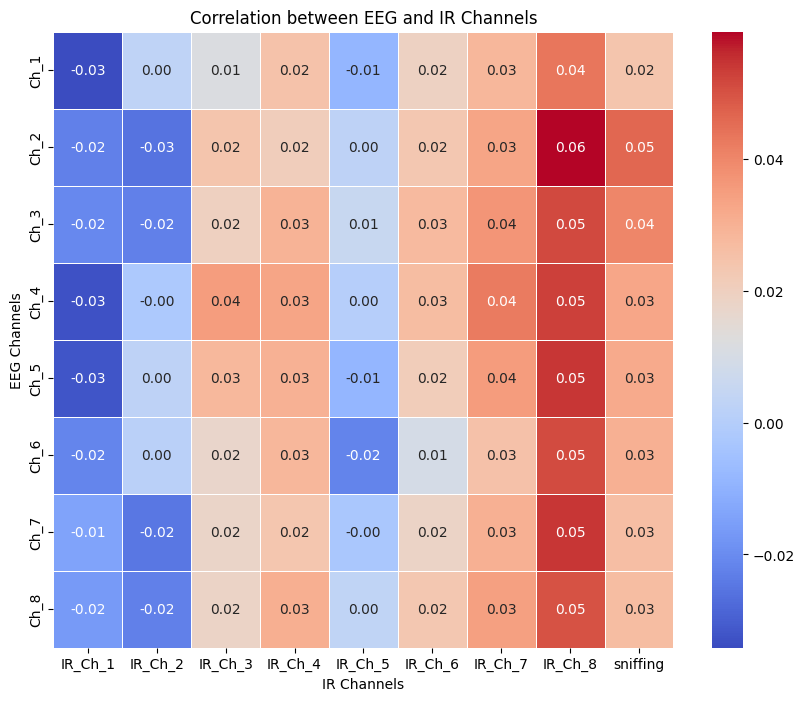

In [ ]:
import seaborn as sns

# Select EEG and IR channels for correlation
eeg_channels = ['Ch_1', 'Ch_2', 'Ch_3', 'Ch_4', 'Ch_5', 'Ch_6', 'Ch_7', 'Ch_8']
ir_channels = ['IR_Ch_1', 'IR_Ch_2', 'IR_Ch_3', 'IR_Ch_4', 'IR_Ch_5', 'IR_Ch_6', 'IR_Ch_7', 'IR_Ch_8', 'sniffing']

# Calculate the correlation matrix
correlation_matrix = merged_nn[eeg_channels + ir_channels].corr()

# Extract the submatrix for EEG vs. IR channels
eeg_ir_correlation = correlation_matrix.loc[eeg_channels, ir_channels]


# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(eeg_ir_correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation between EEG and IR Channels")
plt.xlabel("IR Channels")
plt.ylabel("EEG Channels")
plt.show()


###**1.2 Feature Extraction**

Here I am sliding a small time window across the EEG and IR data to extract useful features like mean, std, and frequency power. By doing this method it is possible to turn raw signals into structured data that can be fed into machine learning models for sniff detection.

Steps involve-
1. importing Welch’s method from scipy.signal so we can grab spectral power in frequency bands.  

2. setting up lists of EEG channels (all cols starting with “Ch_”) and IR channels (carried over smoothed/binarized ones).  

3. defining feature-extraction params: 1 kHz sampling, 0.8 s windows sliding every 0.05 s, and computing window/sample counts.  

4. looping over the data in sliding windows, grabbing the midpoint timestamp for each segment.  

5. pulling time-domain EEG features by tacking on mean and std for each channel.  

6. computing spectral EEG features with Welch, then averaging power in delta, theta, alpha, beta bands.  

7. for IR, adding fraction of window with motion and total onset counts as simple motion features.  

8. labeling each window as sniff (1) or non-sniff (0) by checking if >50% of the window has sniffing flag.  

9. collecting all feat, lbl, t_mid into lists for later DataFrame construction.  

10. finally, building X DataFrame with descriptive column names (per-channel means, stds, band powers, IR features) and y array of labels.  


In [ ]:
from scipy.signal import welch

# 1. Define EEG and IR channel lists
eeg_cols = [col for col in merged_nn.columns if col.startswith('Ch_')]
ir_cols  = ir_cols  # carried over from previous block (your smoothed/binarized IR channels)

# 2. Feature extraction parameters
fs      = 1000
win_s   = 0.8
step_s  = 0.05
win_n   = int(win_s  * fs)
step_n  = int(step_s * fs)

# 3. Sliding‐window feature extraction
features = []
labels   = []
times    = []

for start in range(0, len(merged_nn) - win_n, step_n):
    seg = merged_nn.iloc[start : start + win_n]
    t_mid = seg['Timestamps'].iloc[win_n // 2]

    # EEG time‐domain features
    eeg_vals = seg[eeg_cols].values
    feat = []
    feat += list(eeg_vals.mean(axis=0))
    feat += list(eeg_vals.std(axis=0))
    # EEG spectral features (delta/theta/alpha/beta)
    f, Pxx = welch(eeg_vals, fs=fs, axis=0, nperseg=win_n)
    bands = {'delta': (1,4), 'theta': (4,8), 'alpha': (8,12), 'beta': (12,30)}
    for (low, high) in bands.values():
        idx = (f >= low) & (f <= high)
        feat += list(Pxx[idx, :].mean(axis=0))

    # IR features: motion duty‐cycle & onset count
    ir_vals      = seg[ir_cols].values
    feat.append(ir_vals.mean())             # fraction of window with motion
    onset_cols   = [c for c in merged_nn.columns if c.endswith('_onset')]
    feat.append(seg[onset_cols].sum().sum())

    # Label for this window
    lbl = int(seg['sniffing'].mean() > 0.5)

    # Collect
    features.append(feat)
    labels.append(lbl)
    times.append(t_mid)

# 4. Build DataFrame of features
col_names = (
    [f"{ch}_mean" for ch in eeg_cols] +
    [f"{ch}_std"  for ch in eeg_cols] +
    [f"{ch}_{band}" for band in bands for ch in eeg_cols] +
    ["ir_motion_frac", "ir_onset_count"]
)
X = pd.DataFrame(features, columns=col_names)
y = np.array(labels)
time_midpoints = np.array(times)

In [ ]:
print("Feature matrix shape:", X.shape)
print("Labels distribution:", np.bincount(y))

Feature matrix shape: (7315, 50)
Labels distribution: [7175  140]


Recently was told about this really cool tool- please check out the .html generated!

In [ ]:
!pip install ydata_profiling
from ydata_profiling import ProfileReport
profile = ProfileReport(X, title="Profiling Report")
profile.to_file("final_report.html")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 74.6 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=16f62182a23623d10fa3e06c8df93c81ba21dcd1073df0e7e144ced1ef2ff9fa
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 50/50 [00:01<00:00, 44.78it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# ***PART 2: Model Training:***

Splitting the feature DataFrame X and label array y into train (80%) and test (20%) sets with stratified sampling, then printing the original training class counts.

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import pandas as pd
import numpy as np

# 1. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Original training class counts:", dict(zip(*np.unique(y_train, return_counts=True))))

Applying SMOTE to balance the training data and printing the new class distribution so we don’t bias the model toward the majority class.

In [ ]:
# Apply SMOTE to Training Set
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

print("After SMOTE class counts:", dict(zip(*np.unique(y_train_bal, return_counts=True))))

Initializing and running an XGBClassifier (200 trees, max depth 6, learning rate 0.1, logistic objective, and training it on the balanced data)

In [ ]:
# 3. Initialize & Train XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

xgb.fit(
    X_train_bal,
    y_train_bal,
    eval_set=[(X_test, y_test)],
    verbose=True
)


# 4. Predict & Evaluate
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

feat_imp = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 Most Important Features:\n", feat_imp.head(10))


After SMOTE class counts: {np.int64(0): np.int64(5740), np.int64(1): np.int64(5740)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:33:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.97649
[1]	validation_0-auc:0.97841
[2]	validation_0-auc:0.98028
[3]	validation_0-auc:0.98308
[4]	validation_0-auc:0.98620
[5]	validation_0-auc:0.98568
[6]	validation_0-auc:0.98645
[7]	validation_0-auc:0.98838
[8]	validation_0-auc:0.98807
[9]	validation_0-auc:0.98813
[10]	validation_0-auc:0.98807
[11]	validation_0-auc:0.98737
[12]	validation_0-auc:0.99049
[13]	validation_0-auc:0.99102
[14]	validation_0-auc:0.99087
[15]	validation_0-auc:0.99067
[16]	validation_0-auc:0.99166
[17]	validation_0-auc:0.99241
[18]	validation_0-auc:0.99263
[19]	validation_0-auc:0.99261
[20]	validation_0-auc:0.99306
[21]	validation_0-auc:0.99326
[22]	validation_0-auc:0.99430
[23]	validation_0-auc:0.99517
[24]	validation_0-auc:0.99512
[25]	validation_0-auc:0.99530
[26]	validation_0-auc:0.99547
[27]	validation_0-auc:0.99587
[28]	validation_0-auc:0.99584
[29]	validation_0-auc:0.99607
[30]	validation_0-auc:0.99637
[31]	validation_0-auc:0.99639
[32]	validation_0-auc:0.99669
[33]	validation_0-au

ROC & Precision-Recall Curves

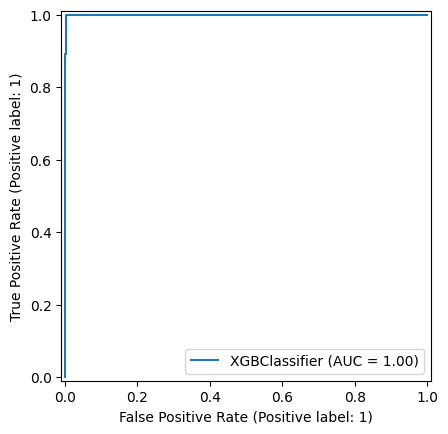

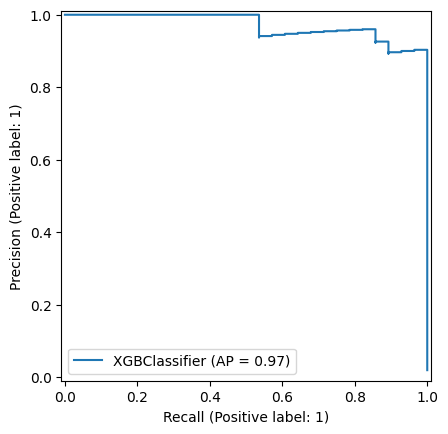

In [ ]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
RocCurveDisplay.from_estimator(xgb, X_test, y_test); plt.show()
PrecisionRecallDisplay.from_estimator(xgb, X_test, y_test); plt.show()


Show training vs validation performance as you grow epochs.


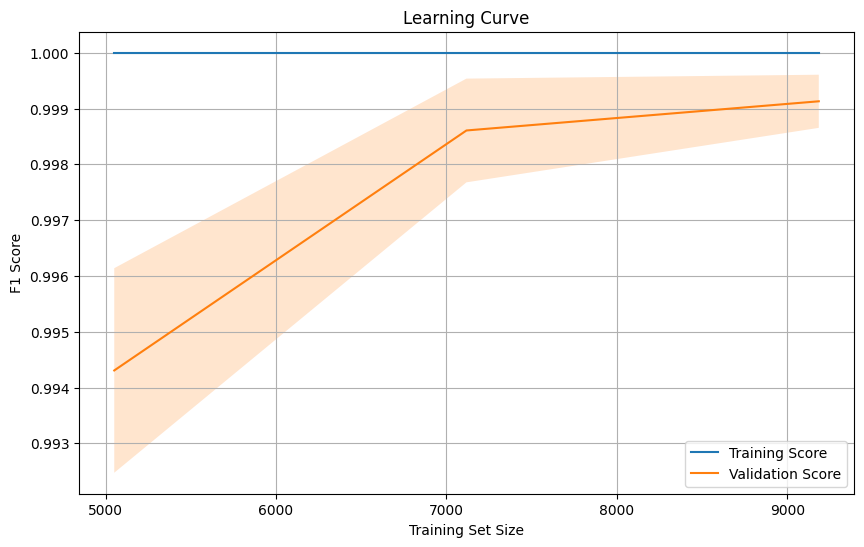

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(
    xgb, X_train_bal, y_train_bal, cv=5, scoring='f1', n_jobs=-1)
# then plot mean±std of train_scores & val_scores vs train_sizes

import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                 np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.2)

plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation Score')
plt.fill_between(train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                 np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.2)

plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


## Other plots

Generating a sniff-locked spectrogram for channel “Ch_1” using a 256-sample window, showing how power in each frequency evolves around the sniff event.

In [ ]:
from scipy import signal

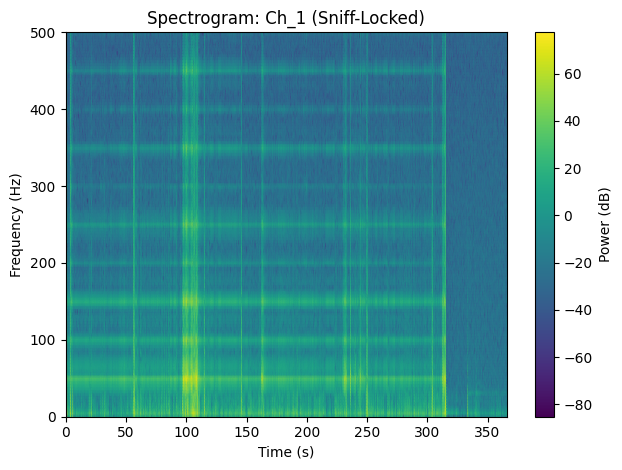

In [ ]:
ch = 'Ch_1'
f, t, Sxx = signal.spectrogram(raw_clean.get_data(picks=[ch])[0], fs=sfreq, nperseg=256)
plt.pcolormesh(t-0.2, f, 10 * np.log10(Sxx), shading='gouraud')
plt.axvline(0, color='r', linestyle='--')
plt.ylabel('Frequency (Hz)'); plt.xlabel('Time (s)')
plt.title(f'Spectrogram: {ch} (Sniff-Locked)')
plt.colorbar(label='Power (dB)'); plt.tight_layout()
plt.show()


See clustering/separability of sniff vs non-sniff windows.

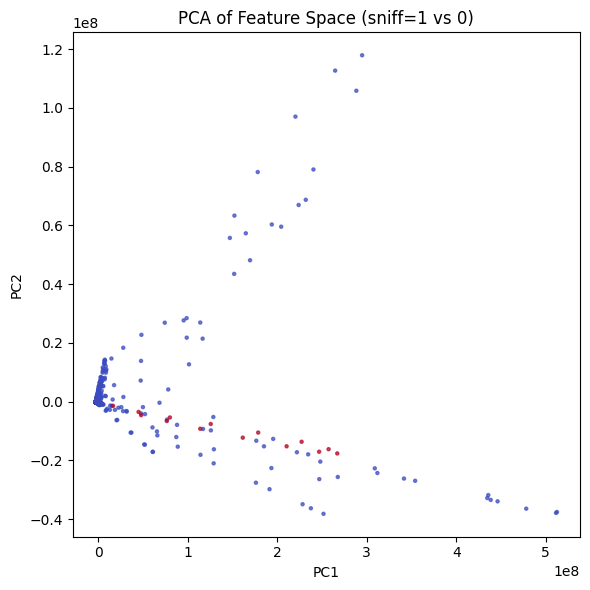

In [ ]:
from sklearn.decomposition import PCA
proj = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(6,6))
plt.scatter(proj[:,0], proj[:,1], c=y, s=5, cmap='coolwarm', alpha=0.7)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('PCA of Feature Space (sniff=1 vs 0)')
plt.tight_layout(); plt.show()


Compare, say, delta-band power in sniff vs non-sniff.

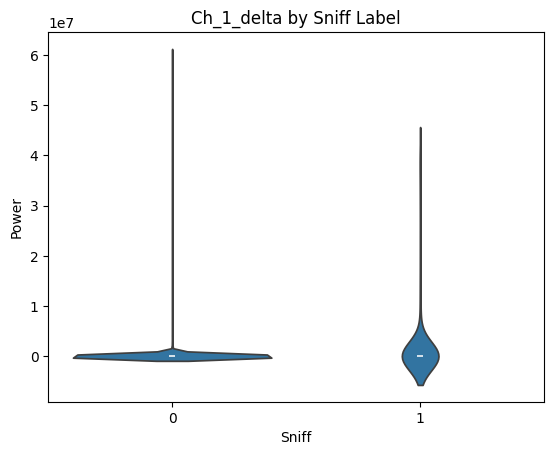

In [ ]:
feat = 'Ch_1_delta'
sns.violinplot(x=y, y=X[feat])
plt.title(f'{feat} by Sniff Label'); plt.xlabel('Sniff'); plt.ylabel('Power'); plt.show()

Feature Importance Bar PLot

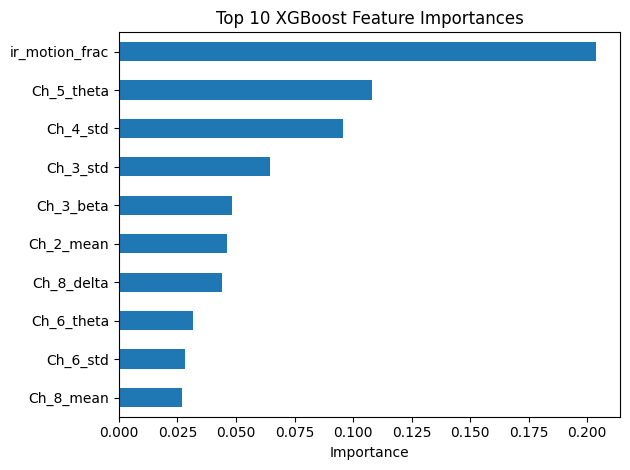

In [ ]:
imp = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=True)
imp.tail(10).plot.barh()
plt.title('Top 10 XGBoost Feature Importances'); plt.xlabel('Importance'); plt.tight_layout()
plt.show()


N.B

In this work, I’ve only used data from the session 060924-1700 to build and test the model. For a stronger and more generalizable model, we could later concatenate data from multiple sessions to get a bigger training and testing set.